In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(123)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

0.0%

100.1%

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


113.5%

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


180.4%

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw
Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

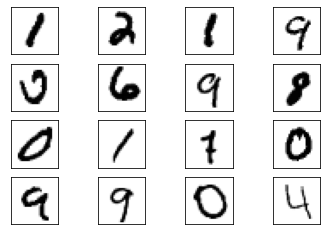

In [7]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [9]:
discriminator = Discriminator().to(device=device)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [11]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5006868243217468
Epoch: 0 Loss G.: 0.6028866767883301
Epoch: 1 Loss D.: 0.0802539810538292
Epoch: 1 Loss G.: 10.653480529785156
Epoch: 2 Loss D.: 0.007485107518732548
Epoch: 2 Loss G.: 6.7299628257751465
Epoch: 3 Loss D.: 0.11082236468791962
Epoch: 3 Loss G.: 7.604299068450928
Epoch: 4 Loss D.: 0.17177005112171173
Epoch: 4 Loss G.: 5.297675609588623
Epoch: 5 Loss D.: 0.07237005978822708
Epoch: 5 Loss G.: 4.874595642089844
Epoch: 6 Loss D.: 0.0027235294692218304
Epoch: 6 Loss G.: 8.600502014160156
Epoch: 7 Loss D.: 0.10247040539979935
Epoch: 7 Loss G.: 5.213729381561279
Epoch: 8 Loss D.: 0.09985291212797165
Epoch: 8 Loss G.: 7.088833808898926
Epoch: 9 Loss D.: 0.0806983932852745
Epoch: 9 Loss G.: 5.224142074584961
Epoch: 10 Loss D.: 0.012265287339687347
Epoch: 10 Loss G.: 4.777778625488281
Epoch: 11 Loss D.: 0.12660998106002808
Epoch: 11 Loss G.: 3.3696722984313965
Epoch: 12 Loss D.: 0.0013117730850353837
Epoch: 12 Loss G.: 6.9360880851745605
Epoch: 13 Loss D.: 0.000

In [22]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

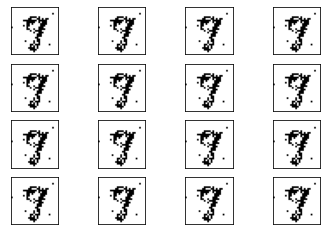

In [31]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])